In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import optuna
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from utils import *

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Import data

In [4]:
SEED = 2020

In [5]:
# load arline data
airline_train = pd.read_csv("./Datasets/airline_sentiment_processed_train.csv", encoding='ISO-8859-1')
airline_test = pd.read_csv("./Datasets/airline_sentiment_processed_test.csv", encoding='ISO-8859-1')
airline = pd.concat([airline_train, airline_test])

In [6]:
# load arline data
sentiment140_negatives1 = pd.read_csv("./Datasets/sentiment140_processed_21_30000.csv", encoding='ISO-8859-1')
sentiment140_negatives2 = pd.read_csv("./Datasets/sentiment140_processed_21_30000.csv", encoding='ISO-8859-1')
sentiment140_positives = pd.read_csv("./Datasets/sentiment140_processed_26_60000.csv", encoding='ISO-8859-1')
sentiment140 = pd.concat([sentiment140_negatives1, sentiment140_negatives2, sentiment140_positives])

In [7]:
%%time
# preprocessing (tokenization, discard long sentence, lowercase etc.)
airline = preproc(airline)

Tokenizing the data...
Length of the data :  11540
CPU times: total: 12.9 s
Wall time: 13.9 s


In [8]:
%%time
# preprocessing (tokenization, discard long sentence, lowercase etc.)
sentiment140 = preproc(sentiment140)

Tokenizing the data...
Length of the data :  119999
CPU times: total: 1min 44s
Wall time: 1min 47s


In [9]:
len(airline), len(sentiment140)

(11540, 119999)

In [10]:
# subsample sentiment140 such that same dataset size
sentiment140 = sentiment140.sample(n=len(airline), random_state=SEED)

In [11]:
len(airline), len(sentiment140)

(11540, 11540)

In [12]:
airline = airline.drop(columns=['len'])
sentiment140 = sentiment140.drop(columns=['len'])

In [13]:
def get_vocab(data):
    # build vocab
    vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}
    for item in data.iloc[:, 0]:
        for word in item:
            if word not in vocab:
                vocab[word] = len(vocab)
    pad_idx = vocab['__PAD__']
    voc_size = len(vocab)
    print("Vocabulary Size A: ", voc_size)

    return pad_idx, voc_size, vocab

In [14]:
pad_idx_airline, voc_size_airline, vocab_airline = get_vocab(airline)

Vocabulary Size A:  7898


In [15]:
pad_idx_sentiment140, voc_size_sentiment140, vocab_sentiment140 = get_vocab(sentiment140)

Vocabulary Size A:  10265


In [16]:
"""pad_idx_combined, voc_size_combined, vocab_combined = get_vocab(pd.concat([airline, sentiment140]))"""

Vocabulary Size A:  12558


# CV

### Definition

In [69]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler
EPOCHS = 'unrestricted'

In [70]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, epochs, pad_idx, voc_size, device, lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch=epochs,
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

### Evaluation

A: sentiment140, B: airline

In [71]:
model_names = ['A', 'B', 'vanilla_pre', 'vanilla_post', 'OT_pre', 'OT_post', 'random']
scoresA = {'loss': {model_name: [] for model_name in model_names},
          'accuracy': {model_name: [] for model_name in model_names},
          'f1': {model_name: [] for model_name in model_names}}
scoresB = {'loss': {model_name: [] for model_name in model_names},
           'accuracy': {model_name: [] for model_name in model_names},
           'f1': {model_name: [] for model_name in model_names}}
scoresAB = {'loss': {model_name: [] for model_name in model_names},
           'accuracy': {model_name: [] for model_name in model_names},
           'f1': {model_name: [] for model_name in model_names}}

Vocabulary Size :  9354


100%|██████████| 2308/2308 [00:00<00:00, 26529.50it/s]


Positive labels ratio (train set): 0.5011915077989602
Positive labels ratio (test set): 0.5064991334488734
Dataset initializing done
Vocabulary Size :  7290


100%|██████████| 2308/2308 [00:00<00:00, 26377.47it/s]


Positive labels ratio (train set): 0.20320623916811092
Positive labels ratio (test set): 0.2110051993067591
Dataset initializing done
Vocabulary Size :  11638


100%|██████████| 4616/4616 [00:00<00:00, 24618.64it/s]


Positive labels ratio (train set): 0.3521988734835355
Positive labels ratio (test set): 0.3587521663778163
Dataset initializing done
Vocabulary Size A:  11638
Starting training for model A


Epoch: 61 - Train Loss: 0.6367 / Validation Loss: 0.6803 / Train acc: 0.6441 / Val acc: 0.5707 / Learning Rate : 0.0000:   0%|          | 61/1000000 [00:57<265:44:15,  1.05it/s]

Training has converged after 61 epochs (lr < 1e-06)


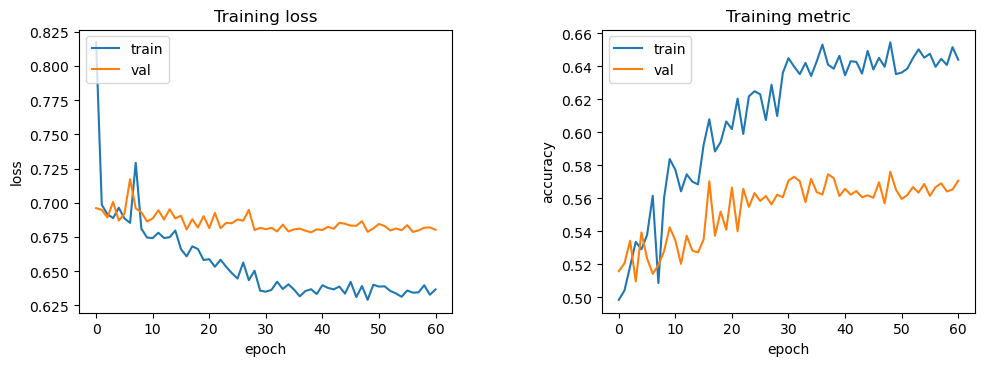

Epoch: 61 - Train Loss: 0.6367 / Validation Loss: 0.6803 / Train acc: 0.6441 / Val acc: 0.5707 / Learning Rate : 0.0000:   0%|          | 61/1000000 [00:57<262:40:55,  1.06it/s]


Starting training for model B


Epoch: 128 - Train Loss: 0.2226 / Validation Loss: 0.3333 / Train acc: 0.9115 / Val acc: 0.8625 / Learning Rate : 0.0000:   0%|          | 128/1000000 [02:04<269:52:13,  1.03it/s]

Training has converged after 128 epochs (lr < 1e-06)


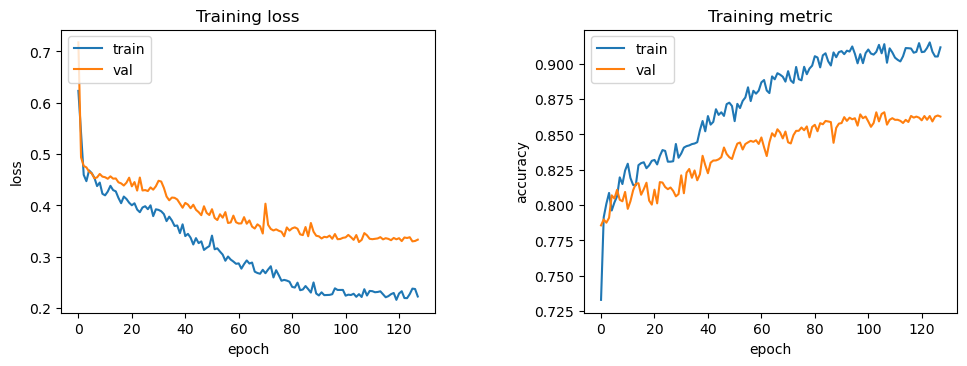

Epoch: 128 - Train Loss: 0.2226 / Validation Loss: 0.3333 / Train acc: 0.9115 / Val acc: 0.8625 / Learning Rate : 0.0000:   0%|          | 128/1000000 [02:04<271:01:23,  1.02it/s]


TESTING A
fusion successful
fusion successful
A loss: 0.6797137379646301 - accuracy: 0.5657031250000001 - f1: 0.5619584321975708
B loss: 1.2228985548019409 - accuracy: 0.48275841346153847 - f1: 0.4926343262195587
random loss: 0.871370267868042 - accuracy: 0.5028305288461539 - f1: 0.5064991116523743
OT_pre loss: 0.7497045636177063 - accuracy: 0.5326322115384615 - f1: 0.5298960208892822
vanilla_pre loss: 0.7631353497505188 - accuracy: 0.5269771634615384 - f1: 0.5307625532150269
Starting retraining for model vanilla fusion


Epoch: 107 - Train Loss: 0.7045 / Validation Loss: 0.7051 / Train acc: 0.5521 / Val acc: 0.5533 / Learning Rate : 0.0000:   0%|          | 107/1000000 [01:36<242:38:42,  1.14it/s]

Training has converged after 107 epochs (lr < 1e-06)


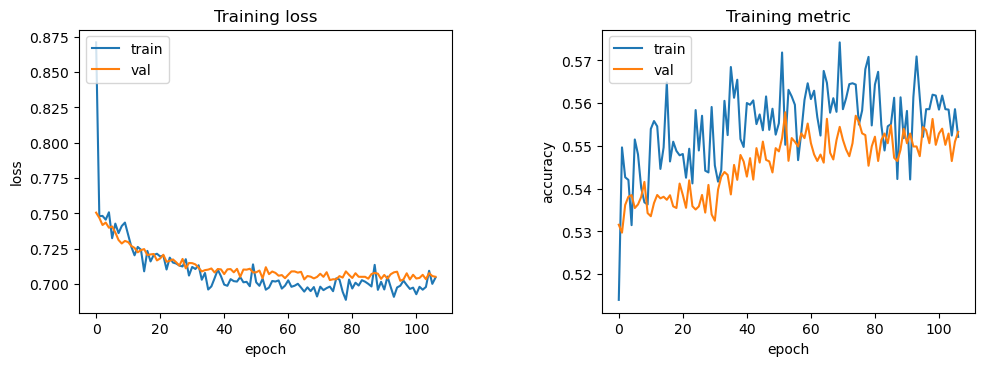

Epoch: 107 - Train Loss: 0.7045 / Validation Loss: 0.7051 / Train acc: 0.5521 / Val acc: 0.5533 / Learning Rate : 0.0000:   0%|          | 107/1000000 [01:37<252:00:44,  1.10it/s]


Starting retraining for model OT fusion


Epoch: 112 - Train Loss: 0.6965 / Validation Loss: 0.7073 / Train acc: 0.5555 / Val acc: 0.5466 / Learning Rate : 0.0000:   0%|          | 112/1000000 [01:36<241:48:09,  1.15it/s]

Training has converged after 112 epochs (lr < 1e-06)


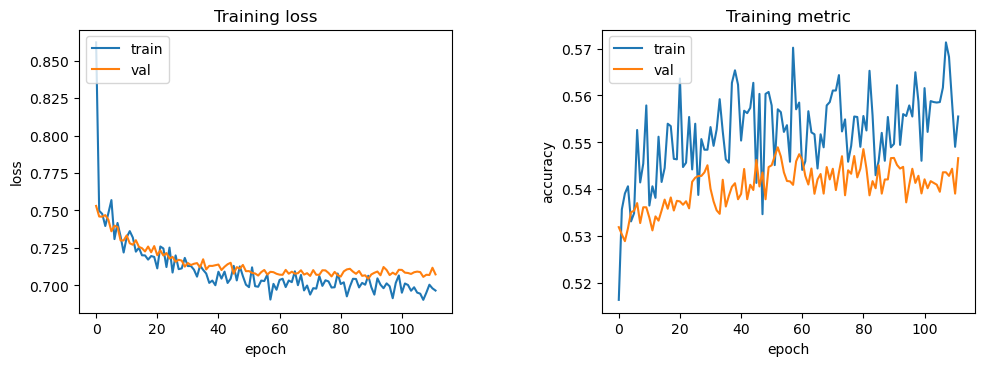

Epoch: 112 - Train Loss: 0.6965 / Validation Loss: 0.7073 / Train acc: 0.5555 / Val acc: 0.5466 / Learning Rate : 0.0000:   0%|          | 112/1000000 [01:36<240:30:04,  1.15it/s]


OT_post loss: 0.7085488677024842 - accuracy: 0.5428245192307692 - f1: 0.5424609780311584
vanilla_post loss: 0.7065825700759888 - accuracy: 0.5509915865384615 - f1: 0.5502599477767944
TESTING B
fusion successful
fusion successful
A loss: 0.7397319555282593 - accuracy: 0.48412860576923084 - f1: 0.4874350130558014
B loss: 0.3275388300418854 - accuracy: 0.8655348557692308 - f1: 0.8613518476486206
random loss: 0.6574176907539367 - accuracy: 0.6509014423076924 - f1: 0.6442807912826538
OT_pre loss: 0.5826483845710755 - accuracy: 0.6882752403846154 - f1: 0.6949740052223206
vanilla_pre loss: 0.48000453114509584 - accuracy: 0.7792487980769232 - f1: 0.7807625532150269
Starting retraining for model vanilla fusion


Epoch: 62 - Train Loss: 0.3371 / Validation Loss: 0.3996 / Train acc: 0.8586 / Val acc: 0.8318 / Learning Rate : 0.0000:   0%|          | 62/1000000 [00:53<241:16:25,  1.15it/s]

Training has converged after 62 epochs (lr < 1e-06)


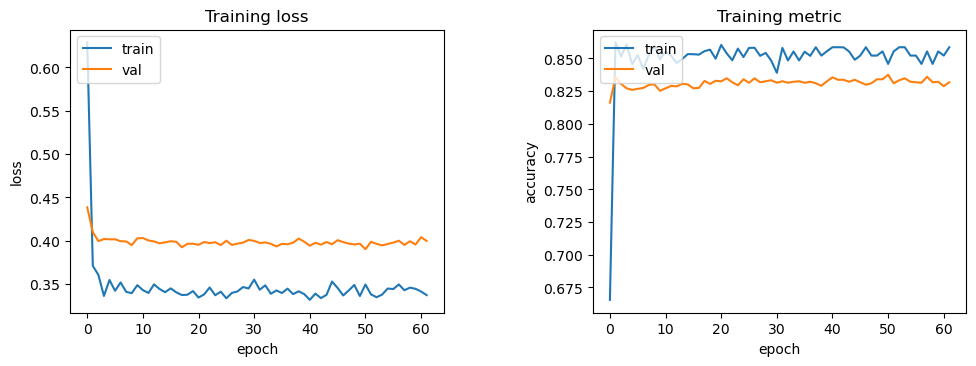

Epoch: 62 - Train Loss: 0.3371 / Validation Loss: 0.3996 / Train acc: 0.8586 / Val acc: 0.8318 / Learning Rate : 0.0000:   0%|          | 62/1000000 [00:54<242:22:06,  1.15it/s]


Starting retraining for model OT fusion


Epoch: 68 - Train Loss: 0.3388 / Validation Loss: 0.3940 / Train acc: 0.8572 / Val acc: 0.8318 / Learning Rate : 0.0000:   0%|          | 68/1000000 [00:58<240:54:24,  1.15it/s]

Training has converged after 68 epochs (lr < 1e-06)


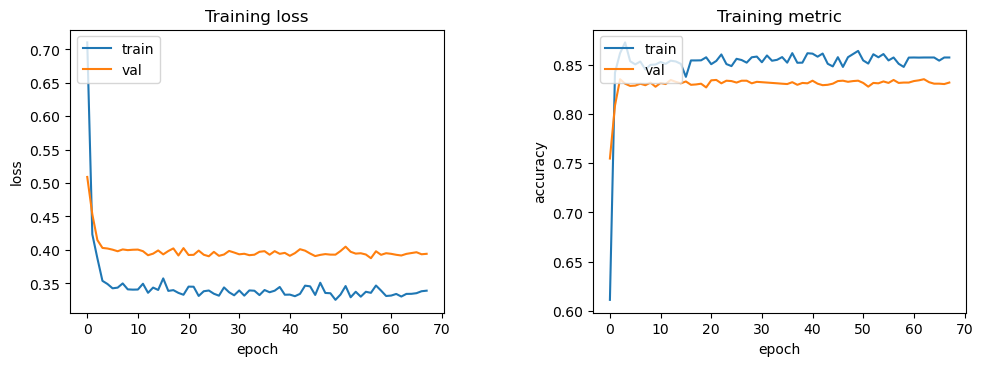

Epoch: 68 - Train Loss: 0.3388 / Validation Loss: 0.3940 / Train acc: 0.8572 / Val acc: 0.8318 / Learning Rate : 0.0000:   0%|          | 68/1000000 [00:58<240:27:34,  1.16it/s]


OT_post loss: 0.3892833888530731 - accuracy: 0.8344411057692309 - f1: 0.832322359085083
vanilla_post loss: 0.3944224536418915 - accuracy: 0.8344411057692309 - f1: 0.832322359085083
TESTING AB
fusion successful
fusion successful
A loss: 0.6991088330745697 - accuracy: 0.542578125 - f1: 0.5472270250320435
B loss: 0.933424174785614 - accuracy: 0.6064453125 - f1: 0.6044194102287292
random loss: 0.6709320187568665 - accuracy: 0.5994140625000001 - f1: 0.6102686524391174
OT_pre loss: 0.6980163216590881 - accuracy: 0.5867187500000001 - f1: 0.5688908100128174
vanilla_pre loss: 0.6515001773834228 - accuracy: 0.6216796875 - f1: 0.6213171482086182
Starting retraining for model vanilla fusion


Epoch: 54 - Train Loss: 0.6427 / Validation Loss: 0.6354 / Train acc: 0.6584 / Val acc: 0.6457 / Learning Rate : 0.0000:   0%|          | 54/1000000 [01:32<485:50:41,  1.75s/it]

Training has converged after 54 epochs (lr < 1e-06)


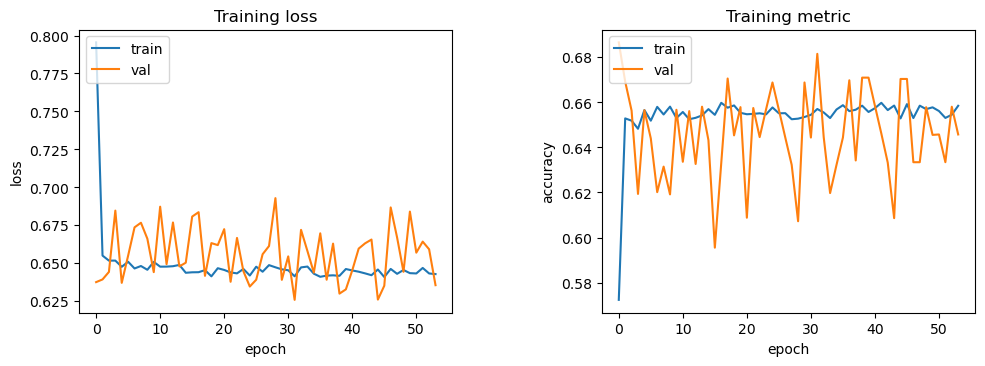

Epoch: 54 - Train Loss: 0.6427 / Validation Loss: 0.6354 / Train acc: 0.6584 / Val acc: 0.6457 / Learning Rate : 0.0000:   0%|          | 54/1000000 [01:32<475:37:39,  1.71s/it]


Starting retraining for model OT fusion


Epoch: 47 - Train Loss: 0.6461 / Validation Loss: 0.6757 / Train acc: 0.6522 / Val acc: 0.6271 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:20<483:23:55,  1.74s/it]

Training has converged after 47 epochs (lr < 1e-06)


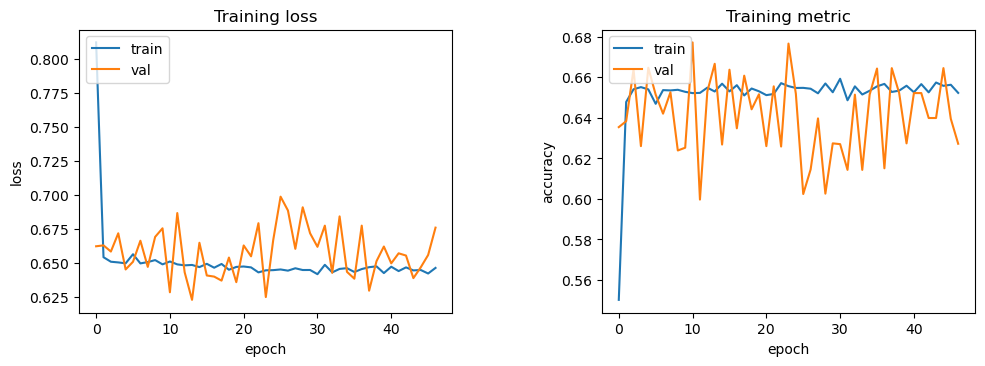

Epoch: 47 - Train Loss: 0.6461 / Validation Loss: 0.6757 / Train acc: 0.6522 / Val acc: 0.6271 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:21<479:14:51,  1.73s/it]


OT_post loss: 0.6618063747882843 - accuracy: 0.6271484375 - f1: 0.6410312056541443
vanilla_post loss: 0.6525103867053985 - accuracy: 0.6333984375 - f1: 0.6479635834693909
CPU times: total: 11min 8s
Wall time: 11min 9s


In [72]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    # train, test sets
    train_setA, test_setA = train_test_split(sentiment140, test_size=0.2, random_state=SEED)
    train_iteratorA, test_iteratorA, voc_sizeA, pad_idxA, embeddingA = build_generators(train_setA, test_setA, device, batch_size=512)

    train_setB, test_setB = train_test_split(airline, test_size=0.2, random_state=SEED)
    train_iteratorB, test_iteratorB, voc_sizeB, pad_idxB, embeddingB = build_generators(train_setB, test_setB, device, batch_size=512)

    train_setAB, test_setAB = pd.concat([train_setA, train_setB]), pd.concat([test_setA, test_setB])
    train_iteratorAB, test_iteratorAB, voc_sizeAB, pad_idxAB, embeddingAB = build_generators(train_setAB, test_setAB, device, batch_size=512)

    # combined embedding
    pad_idx_combined, voc_size_combined, vocab_combined = get_vocab(pd.concat([train_setA, train_setB]))
    embedding_combined = torch.nn.Embedding(voc_size_combined, 16)

    # train model A (sentimental140)
    print('Starting training for model A')
    modelA = train_early_stopping(model_name='A',
                                  train_iter=train_iteratorA,
                                  valid_iter=test_iteratorA,
                                  embedding=embedding_combined,
                                  epochs=EPOCHS,
                                  pad_idx=pad_idx_combined,
                                  voc_size=voc_size_combined,
                                  device=device,
                                  lr=LEARNING_RATE,
                                  save=False)

    # train model B (airline)
    print('Starting training for model B')
    modelB = train_early_stopping(model_name='B',
                                  train_iter=train_iteratorB,
                                  valid_iter=test_iteratorB,
                                  embedding=embedding_combined,
                                  epochs=EPOCHS,
                                  pad_idx=pad_idx_combined,
                                  voc_size=voc_size_combined,
                                  device=device,
                                  lr=LEARNING_RATE,
                                  save=False)

    """# model fusion
    # 1) vanilla
    model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx_combined,
                                          voc_size=voc_size_combined, embedding=embedding_combined, device=device)
    # 2) optimal transport - TODO: WITH RESPECT TO TRAIN_ITERATOR A (WE HAVE TO CHOOSE ONE)!! -
    model_fusion = ot_fusion(modelA, modelB, train_iteratorA, embedding_combined, pad_idx_combined, voc_size_combined, device, fusion_ratio=0.5)

    # ensure all models on same device
    modelA = modelA.to(device)
    modelB = modelB.to(device)
    model_random = new_model(embedding_combined, pad_idx_combined, voc_size_combined, device)
    model_fusion = model_fusion.to(device)
    model_fusion_vanilla = model_fusion_vanilla.to(device)

    # store untrained models
    model_fusion_vanilla_pre = new_model(embedding_combined, pad_idx_combined, voc_size_combined, device)
    model_fusion_vanilla_pre.load_state_dict(model_fusion_vanilla_pre.state_dict())

    model_fusion_pre = new_model(embedding_combined, pad_idx_combined, voc_size_combined, device)
    model_fusion_pre.load_state_dict(model_fusion_pre.state_dict())"""

    # TEST W.R.T A
    print('TESTING A')
    train_iterator_fusion = train_iteratorA
    test_iterator_fusion = test_iteratorA

    # model fusion
    # 1) vanilla
    model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx_combined,
                                          voc_size=voc_size_combined, embedding=embedding_combined, device=device)
    # 2) optimal transport
    model_fusion = ot_fusion(modelA, modelB, train_iterator_fusion, embedding_combined, pad_idx_combined, voc_size_combined, device, fusion_ratio=0.5)

    # ensure all models on same device
    modelA = modelA.to(device)
    modelB = modelB.to(device)
    model_random = new_model(embedding_combined, pad_idx_combined, voc_size_combined, device)
    model_fusion = model_fusion.to(device)
    model_fusion_vanilla = model_fusion_vanilla.to(device)

    # test models
    for name, model in zip(('A', 'B', 'random', 'OT_pre', 'vanilla_pre'), (modelA, modelB, model_random, model_fusion, model_fusion_vanilla)):
        loss, acc, f1 = validation(model, test_iterator_fusion, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
        loss = to_cpu(loss)
        acc = to_cpu(acc)
        f1 = to_cpu(f1)

        print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
        scoresA['loss'][name].append(loss), scoresA['accuracy'][name].append(acc), scoresA['f1'][name].append(f1)

    # retraining
    retrain = lambda x: train(model=x,
                              iterator=train_iterator_fusion,
                              valid_iter=test_iterator_fusion,
                              optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                              criterion=nn.CrossEntropyLoss(),
                              epoch=EPOCHS,
                              clip=1,
                              device=device)
    # 1) vanilla
    # train with early stopping
    print('Starting retraining for model vanilla fusion')
    retrain(model_fusion_vanilla)

    # 2) optimal transport
    # train with early stopping
    print('Starting retraining for model OT fusion')
    retrain(model_fusion)

    # evaluate
    # test models
    for name, model in zip(('OT_post', 'vanilla_post'), (model_fusion, model_fusion_vanilla)):
        loss, acc, f1 = validation(model, test_iterator_fusion, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
        loss = to_cpu(loss)
        acc = to_cpu(acc)
        f1 = to_cpu(f1)

        print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
        scoresA['loss'][name].append(loss), scoresA['accuracy'][name].append(acc), scoresA['f1'][name].append(f1)


    # TEST W.R.T B
    print('TESTING B')
    train_iterator_fusion = train_iteratorB
    test_iterator_fusion = test_iteratorB

    # model fusion
    # 1) vanilla
    model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx_combined,
                                          voc_size=voc_size_combined, embedding=embedding_combined, device=device)
    # 2) optimal transport
    model_fusion = ot_fusion(modelA, modelB, train_iterator_fusion, embedding_combined, pad_idx_combined, voc_size_combined, device, fusion_ratio=0.5)

    # ensure all models on same device
    modelA = modelA.to(device)
    modelB = modelB.to(device)
    model_random = new_model(embedding_combined, pad_idx_combined, voc_size_combined, device)
    model_fusion = model_fusion.to(device)
    model_fusion_vanilla = model_fusion_vanilla.to(device)

    # test models
    for name, model in zip(('A', 'B', 'random', 'OT_pre', 'vanilla_pre'), (modelA, modelB, model_random, model_fusion, model_fusion_vanilla)):
        loss, acc, f1 = validation(model, test_iterator_fusion, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
        loss = to_cpu(loss)
        acc = to_cpu(acc)
        f1 = to_cpu(f1)

        print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
        scoresB['loss'][name].append(loss), scoresB['accuracy'][name].append(acc), scoresB['f1'][name].append(f1)

    # retraining
    retrain = lambda x: train(model=x,
                              iterator=train_iterator_fusion,
                              valid_iter=test_iterator_fusion,
                              optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                              criterion=nn.CrossEntropyLoss(),
                              epoch=EPOCHS,
                              clip=1,
                              device=device)
    # 1) vanilla
    # train with early stopping
    print('Starting retraining for model vanilla fusion')
    retrain(model_fusion_vanilla)

    # 2) optimal transport
    # train with early stopping
    print('Starting retraining for model OT fusion')
    retrain(model_fusion)

    # evaluate
    # test models
    for name, model in zip(('OT_post', 'vanilla_post'), (model_fusion, model_fusion_vanilla)):
        loss, acc, f1 = validation(model, test_iterator_fusion, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
        loss = to_cpu(loss)
        acc = to_cpu(acc)
        f1 = to_cpu(f1)

        print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
        scoresB['loss'][name].append(loss), scoresB['accuracy'][name].append(acc), scoresB['f1'][name].append(f1)


    # TEST W.R.T AB
    print('TESTING AB')
    train_iterator_fusion = train_iteratorAB
    test_iterator_fusion = test_iteratorAB

    # model fusion
    # 1) vanilla
    model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx_combined,
                                          voc_size=voc_size_combined, embedding=embedding_combined, device=device)
    # 2) optimal transport
    model_fusion = ot_fusion(modelA, modelB, train_iterator_fusion, embedding_combined, pad_idx_combined, voc_size_combined, device, fusion_ratio=0.5)

    # ensure all models on same device
    modelA = modelA.to(device)
    modelB = modelB.to(device)
    model_random = new_model(embedding_combined, pad_idx_combined, voc_size_combined, device)
    model_fusion = model_fusion.to(device)
    model_fusion_vanilla = model_fusion_vanilla.to(device)

    # test models
    for name, model in zip(('A', 'B', 'random', 'OT_pre', 'vanilla_pre'), (modelA, modelB, model_random, model_fusion, model_fusion_vanilla)):
        loss, acc, f1 = validation(model, test_iterator_fusion, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
        loss = to_cpu(loss)
        acc = to_cpu(acc)
        f1 = to_cpu(f1)

        print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
        scoresAB['loss'][name].append(loss), scoresAB['accuracy'][name].append(acc), scoresAB['f1'][name].append(f1)

    # retraining
    retrain = lambda x: train(model=x,
                              iterator=train_iterator_fusion,
                              valid_iter=test_iterator_fusion,
                              optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                              criterion=nn.CrossEntropyLoss(),
                              epoch=EPOCHS,
                              clip=1,
                              device=device)
    # 1) vanilla
    # train with early stopping
    print('Starting retraining for model vanilla fusion')
    retrain(model_fusion_vanilla)

    # 2) optimal transport
    # train with early stopping
    print('Starting retraining for model OT fusion')
    retrain(model_fusion)

    # evaluate
    # test models
    for name, model in zip(('OT_post', 'vanilla_post'), (model_fusion, model_fusion_vanilla)):
        loss, acc, f1 = validation(model, test_iterator_fusion, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
        loss = to_cpu(loss)
        acc = to_cpu(acc)
        f1 = to_cpu(f1)

        print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
        scoresAB['loss'][name].append(loss), scoresAB['accuracy'][name].append(acc), scoresAB['f1'][name].append(f1)

### Export as LaTeX

In [73]:
model_names_latex = ['Model A', 'Model B', 'Vanilla', 'Vanilla (retraining)', 'Optimal transport', 'Optimal transport (retraining)', 'Untrained model (baseline)']

In [74]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    latexA = scores_to_latex(scoresA, model_names_latex)
    latexB = scores_to_latex(scoresB, model_names_latex)
    latexAB = scores_to_latex(scoresAB, model_names_latex)

                 loss accuracy       f1
A              [0.68]  [0.566]  [0.562]
B             [1.223]  [0.483]  [0.493]
vanilla_pre   [0.763]  [0.527]  [0.531]
vanilla_post  [0.707]  [0.551]   [0.55]
OT_pre         [0.75]  [0.533]   [0.53]
OT_post       [0.709]  [0.543]  [0.542]
random        [0.871]  [0.503]  [0.506]
\begin{table}[H]
\centering
\caption{Model performance (5-fold CV)}
\begin{tabular}{llll}
\toprule
{} &              Loss &           Accuracy &           F1 score \\
\midrule
\textbf{Model A                       } &  \textbf{0.68 ± 0.0} &  \textbf{0.566 ± 0.0} &  \textbf{0.562 ± 0.0} \\
\textbf{Model B                       } &       1.223 ± 0.0 &        0.483 ± 0.0 &        0.493 ± 0.0 \\
\textbf{Vanilla                       } &       0.763 ± 0.0 &        0.527 ± 0.0 &        0.531 ± 0.0 \\
\textbf{Vanilla (retraining)          } &       0.707 ± 0.0 &        0.551 ± 0.0 &         0.55 ± 0.0 \\
\textbf{Optimal transport             } &        0.75 ± 0.0 &        0.533 

In [75]:
# save as latex (in text format) (optional)
with open('./Output/scores_different_datasets_A.txt','w') as dat:
    dat.write(str(latexA))
with open('./Output/scores_different_datasets_B.txt','w') as dat:
    dat.write(str(latexB))
with open('./Output/scores_different_datasets_AB.txt','w') as dat:
    dat.write(str(latexAB))